In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, r2_score
import os
from dotenv import load_dotenv
import yfinance as yf
import pandas as pd
import pandas_ta as ta
from scikeras.wrappers import KerasRegressor
# Load environment variables from the .env file
load_dotenv('../.env');

# Data Viz. 
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.ndimage import gaussian_filter
from calendar import monthrange
from calendar import month_name

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
import requests
import csv
from itertools import permutations
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf

import statsmodels.graphics.tsaplots as tsaplot
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing, SimpleExpSmoothing

import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
from ta import add_all_ta_features
from sklearn.linear_model import LinearRegression

def load_and_prepare(ticker, start_date, end_date):
    # Fetch historical stock data
    df = yf.download(ticker, start=start_date , end=end_date)

    # Calculate daily returns
    df['returns'] = df['Adj Close'].pct_change()

    # Fetch market data (e.g., S&P 500)
    market_data = yf.download('^GSPC', start=df.index.min(), end=df.index.max())
    market_data['market_returns'] = market_data['Adj Close'].pct_change()

    # Combine stock and market data
    merged_data = pd.merge(df, market_data[['market_returns']], left_index=True, right_index=True, how='inner')

    # Drop rows with missing values
    merged_data.dropna(inplace=True)

    # Initialize lists to store alpha and beta values
    alpha_values = []
    beta_values = []

    # Set up X and y for linear regression
    X = merged_data['market_returns'].values.reshape(-1, 1)
    y = merged_data['returns'].values

    # Iterate through the data to calculate alpha and beta for each day
    for i in range(len(merged_data)):
        X_i = X[:i + 1]
        y_i = y[:i + 1]

        # Fit linear regression model
        model = LinearRegression()
        model.fit(X_i, y_i)

        # Extract alpha and beta for the current day
        alpha_i = model.intercept_
        beta_i = model.coef_[0]

        alpha_values.append(alpha_i)
        beta_values.append(beta_i)

    # Add alpha and beta columns to the DataFrame
    merged_data['alpha'] = alpha_values
    merged_data['beta'] = beta_values

    # Drop columns not needed for the final result
    merged_data.drop(['returns', 'market_returns'], axis=1, inplace=True)

    # Add technical analysis features
    merged_data = add_all_ta_features(merged_data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

    # Calculate target and target class
    merged_data['target'] = ((merged_data['Close'] - merged_data['Open']) / merged_data['Open']) * 100
    merged_data['target'] = merged_data['target'].shift(-1)
 
    merged_data['target_class'] = np.select(
    [(merged_data['target'] < -1), (merged_data['target'] > 1)],
    [-1, 1],
    default=0
    )
    
    merged_data['target_next_close'] = merged_data['Close'].shift(-1)

    # Drop rows with missing values
    merged_data.dropna(inplace=True)

    return merged_data




In [3]:

stock_data = load_and_prepare('AMZN', "2014-01-01" , "2024-01-01")
stock_data.head()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,alpha,beta,volume_adi,volume_obv,...,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,target,target_class,target_next_close
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-03,19.914499,20.1355,19.811001,19.822001,19.822001,44204000,-0.003845,0.000000,-4.120720e+07,44204000,...,0.0,0.000000,0.000000,0.000000,-76.515626,0.000000,0.000000,-0.560819,0,19.681499
2014-01-06,19.792500,19.8500,19.421000,19.681499,19.681499,63412000,-0.003349,1.488720,-2.760852e+07,-19208000,...,0.0,3.358249,0.671650,2.686599,-0.708814,-0.711338,-0.708814,0.756885,0,19.901501
2014-01-07,19.752001,19.9235,19.714500,19.901501,19.901501,38320000,-0.002265,2.174661,2.644331e+06,19112000,...,0.0,1.582878,0.853896,0.728983,1.117807,1.111606,0.401071,0.865815,0,20.096001
2014-01-08,19.923500,20.1500,19.802000,20.096001,20.096001,46330000,0.001083,1.880616,3.459632e+07,65442000,...,0.0,1.556360,0.994388,0.561971,0.977313,0.972568,1.382303,-0.668789,0,20.050501
2014-01-09,20.185499,20.3445,19.922001,20.050501,20.050501,42060000,0.000261,1.912235,1.812082e+07,23382000,...,0.0,0.770345,0.949580,-0.179235,-0.226412,-0.226669,1.152761,-1.209847,-1,19.882999


In [4]:
stock_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'alpha', 'beta',
       'volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 'volume_mfi',
       'volume_em', 'volume_sma_em', 'volume_vpt', 'volume_nvi', 'volume_vwap',
       'volatility_atr', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kcw', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm',
       'volatility_dcw', 'volatility_dcp', 'volatility_ui', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow', 'trend_adx',
       'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', '

In [5]:
df = stock_data

In [6]:
df.isna().sum()

Open                 0
High                 0
Low                  0
Close                0
Adj Close            0
                    ..
others_dlr           0
others_cr            0
target               0
target_class         0
target_next_close    0
Length: 94, dtype: int64

In [7]:
from sklearn.model_selection import train_test_split

# Assuming X is your feature set and y is your target variable
X = df.drop(['Open', 'High', 'Low', 'Close', 'Volume','target',
       'target_class', 'target_next_close'], axis=1)# Adjust columns accordingly

y = df[['target_class']]  # Adjust the target variable accordingly

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [8]:

# Create a preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler(feature_range=(0,1)))
])

# Apply the preprocessing pipeline to numeric features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', preprocessing_pipeline, X_train.columns)
    ])


# Fit and transform the training data
train_features_preprocessed = preprocessor.fit_transform(X_train)

# Transform the test data using the learned parameters from the training data
test_features_preprocessed = preprocessor.transform(X_test)

# train_features_preprocessed and test_features_preprocessed are preprocessed data

# Reshape training data
X_train_lstm = train_features_preprocessed.reshape((train_features_preprocessed.shape[0], 1, train_features_preprocessed.shape[1]))

# Reshape testing data
X_test_lstm = test_features_preprocessed.reshape((test_features_preprocessed.shape[0], 1, test_features_preprocessed.shape[1]))

model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(units=3, activation='softmax'))  # 3 units for your three categories
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(X_train_lstm, y_train, epochs=50, batch_size=32)



2024-01-11 15:27:32.332630: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-01-11 15:27:32.332656: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-01-11 15:27:32.332662: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-01-11 15:27:32.332703: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-11 15:27:32.332721: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2024-01-11 15:27:33.551325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 5s 39ms/step - loss: 0.5851 - accuracy: 0.5443
Epoch 2/50
63/63 [==============================] - 1s 11ms/step - loss: 0.5449 - accuracy: 0.5194
Epoch 3/50
63/63 [==============================] - 1s 11ms/step - loss: 0.5836 - accuracy: 0.5179
Epoch 4/50
63/63 [==============================] - 1s 11ms/step - loss: 0.6488 - accuracy: 0.4796
Epoch 5/50
63/63 [==============================] - 1s 11ms/step - loss: 0.7649 - accuracy: 0.4791
Epoch 6/50
63/63 [==============================] - 1s 11ms/step - loss: 0.9789 - accuracy: 0.4572
Epoch 7/50
63/63 [==============================] - 1s 11ms/step - loss: 1.1482 - accuracy: 0.4627
Epoch 8/50
63/63 [==============================] - 1s 11ms/step - loss: 1.2367 - accuracy: 0.4617
Epoch 9/50
63/63 [==============================] - 1s 11ms/step - loss: 1.3095 - accuracy: 0.4672
Epoch 10/50
63/63 [==============================] - 1s 11ms/step - loss: 1.3026 - accuracy: 0.4716
Epoch 11/50
63/63 [=

16/16 [==============================] - 2s 56ms/step - loss: 0.5596 - accuracy: 0.2485
Test Loss: 0.5596351027488708, Test Accuracy: 0.24850894510746002


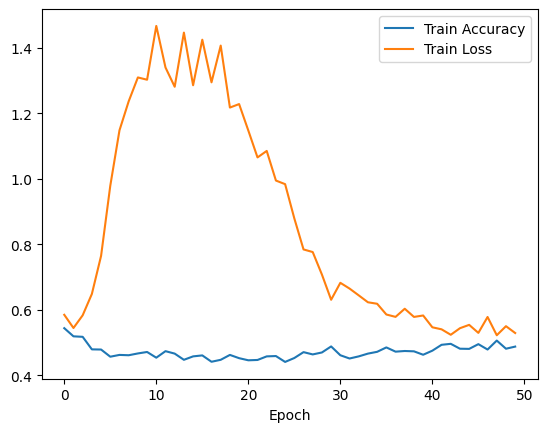

In [9]:
# Evaluate the model on the test set
evaluation = model.evaluate(X_test_lstm, y_test)
print(f"Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}")

# Plot the training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


16/16 [==============================] - 1s 32ms/step


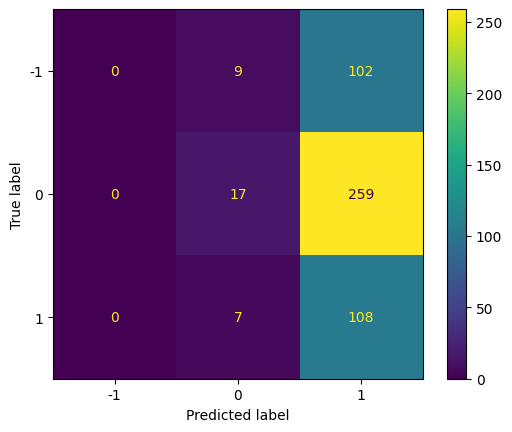

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions on the test set
predictions = model.predict(X_test_lstm)
predicted_classes = np.argmax(predictions, axis=1)

# Create a confusion matrix
cm = confusion_matrix(y_test, predicted_classes, labels=[-1, 0, 1])

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 0, 1])
disp.plot(cmap='viridis', values_format='d')
plt.show()


In [11]:
from sklearn.metrics import classification_report

# Print the classification report
print(classification_report(y_test, predicted_classes))


              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       111
           0       0.52      0.06      0.11       277
           1       0.23      0.94      0.37       115
           2       0.00      0.00      0.00         0

    accuracy                           0.25       503
   macro avg       0.19      0.25      0.12       503
weighted avg       0.34      0.25      0.14       503



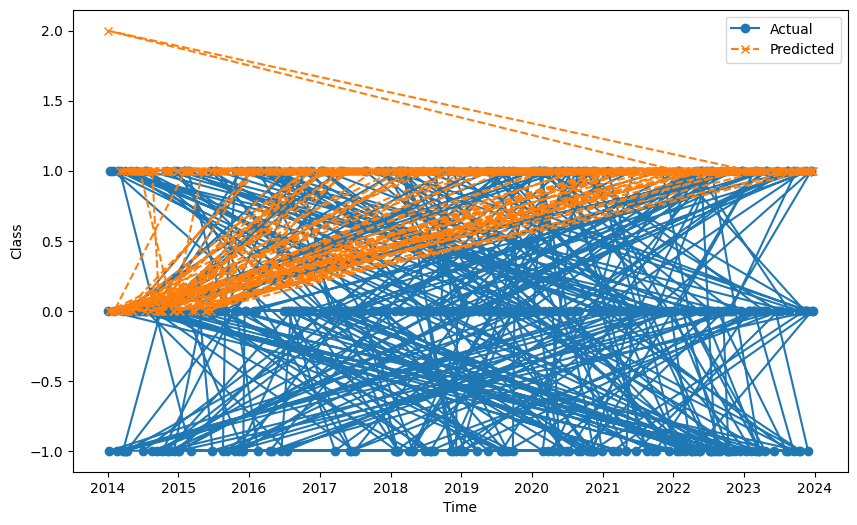

In [12]:
# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', marker='o')
plt.plot(y_test.index, predicted_classes, label='Predicted', marker='x', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Class')
plt.legend()
plt.show()


In [13]:
# Preprocess the new data
X_new_preprocessed = preprocessor.transform(X_new)
X_new_lstm = X_new_preprocessed.reshape((X_new_preprocessed.shape[0], 1, X_new_preprocessed.shape[1]))

# Make predictions on new data
predictions_new = model.predict(X_new_lstm)
predicted_classes_new = np.argmax(predictions_new, axis=1)
print("Predicted Classes for New Data:")
print(predicted_classes_new)


NameError: name 'X_new' is not defined

In [ ]:
print(classification_report(y_test, y_pred_gb))

In [ ]:
from xgboost import XGBClassifier

In [ ]:
gb = XGBClassifier(random_state=42,
                    n_jobs=-1,
                    n_estimators=1000,
                    learning_rate=0.3,
                    #subsample=0.5, 
                    )

In [ ]:
gb.fit(train_features_preprocessed,y_train)

In [ ]:
y_pred_gb = gb.predict(test_features_preprocessed)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test, y_pred_gb))

In [ ]:
cm = confusion_matrix(y_test, y_pred_gb)

# Plot with seaborn
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [ ]:
from sklearn.decomposition import PCA
# Apply PCA
pca = PCA(n_components=25)  # Choose the number of components you want to keep
X_train_pca = pca.fit_transform(train_features_preprocessed)
X_test_pca = pca.transform(test_features_preprocessed)

In [ ]:
gb.fit(X_train_pca,y_train)

In [ ]:
y_pred_gb_pca = gb.predict(X_test_pca)

In [ ]:
print(classification_report(y_test, y_pred_gb_pca))